In [96]:
import matplotlib.pyplot as plt

from copy import copy
from math import copysign
from pathlib import Path
from sys import path
from itertools import accumulate

import numpy as np

from ruckig import InputParameter, OutputParameter, Result, Ruckig, Trajectory

In [97]:
import re
def melody_tokens(description):
    duration = 4
    melody_tokens= []
    for n in description.split(" "):
        m = re.search(r'([a-z]+)([0-9]*)', n)
        d = duration if not m.group(2) else int(m.group(2))
        melody_tokens.append( (m.group(1), d) )
    return melody_tokens

# setup melody
all_my_ducklings= melody_tokens(r'c4 d e f g2 g2 a a a a g1')
trial = melody_tokens(r'c4 d e')

In [98]:
# ground notes in equidistant positions
notes= [["c"], ["cis","des"], ["d"], ["dis", "es"], ["e"], ["f"], ["fis","ges"], ["g"], ["gis","as"], ["a"], ["b"], ["h"]]
note_distance= 0.3

dist = 0.0
note_positions = dict()
for n in notes:
    for name in n:
        note_positions[name]= dist
    dist+= note_distance

#note_positions

In [99]:
melody = all_my_ducklings
#melody = trial
melody_positions= [note_positions[t[0]] for t in melody]

In [100]:
# Create instances: the Ruckig OTG as well as input and output parameters
cycle_time = 0.01
pluck_velocity = 0.5

otg = Ruckig(1, cycle_time)  # DoFs, control cycle
inp = InputParameter(1)
out = OutputParameter(1)

# Set input parameters
inp.max_velocity = [10.0]
inp.max_acceleration = [2.0]
inp.max_jerk = [2.0]

inp.current_position = [-0.1]
inp.current_velocity = [0.0]
inp.current_acceleration = [0.0]

inp.target_position = [0.0]
inp.target_velocity = [0.0]
inp.target_acceleration = [0.0]

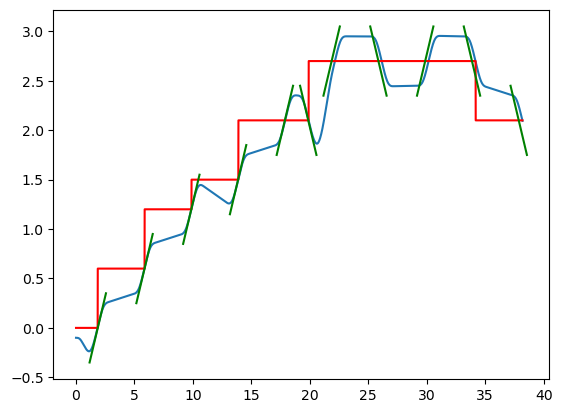

In [101]:
# Generate the trajectory within the control loop
out_list = []
out_target_positions = []
melody_decided_pluck_velocities = []
duration= 0.0

abs_duration= 0.0
first_goal_time= None
for note in melody:
    inp.minimum_duration= duration
    duration= note[1]

    otg.reset()
    inp.target_position= [note_positions[note[0]]]

    # bad heuristic to decide from which direction to approach for pluck
    inp.target_velocity= [copysign(pluck_velocity, inp.target_position[0]-inp.current_position[0])]
    #inp.target_velocity= [pluck_velocity]
    melody_decided_pluck_velocities.append(inp.target_velocity)

    res = Result.Working
    while res == Result.Working:
        res = otg.update(inp, out)
        out_list.append(copy(out))
        out_target_positions.append(inp.target_position)
        out.pass_to_input(inp)
        abs_duration+= cycle_time
    if first_goal_time == None:
        first_goal_time = abs_duration

fig = plt.figure()
T= cycle_time*np.array(range(len(out_list)), dtype= float)
plt.plot(T, [o.new_position[0] for o in out_list], '-', label='0')
plt.plot(T, out_target_positions, '-r')

actual_note_times = first_goal_time + np.add.accumulate(np.array([0.0]+list(map(lambda x: x[1], melody[0:-1]))))
#plt.plot(actual_note_times, melody_positions, 'xg')
delta= 0.7*np.array([-1.0, 1.0])
for (t,p,v) in zip(actual_note_times, melody_positions, melody_decided_pluck_velocities):
    plt.plot(t+delta, p+v*delta, '-g')

In [102]:
otg.reset()
inp.target_position= [0.0]
inp.target_velocity= [0.0]
inp.current_position= [1.0]
inp.current_velocity= [0.0]

t= Trajectory(1)
res= otg.calculate(inp, t)
print(res)

Result.Working


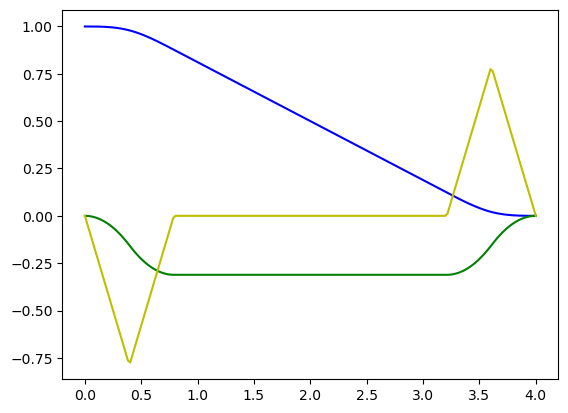

In [109]:
n_wp=200
T= np.linspace(0.0, t.duration, n_wp)
Y= np.zeros((3,n_wp))
for i in range(n_wp):
    Y[0:3,i] = np.array([x[0] for x in t.at_time(T[i])])

plt.plot(T, Y[0,:], color='b')
plt.plot(T, Y[1,:], color='g')
plt.plot(T, Y[2,:], color='y')

In [133]:
otg.reset()
inp.current_position= [1.0]
inp.current_velocity= [0.0]

inp.target_position= [0.0]
inp.target_velocity= [1.0]
t1= Trajectory(1)
res= otg.calculate(inp, t1)
print(res)

t2= Trajectory(2)
inp.current_position, inp.current_velocity, inp.current_acceleration = t1.at_time(t1.duration)
print(t1.at_time(t1.duration))
inp.target_position= [1.0]
inp.target_velocity= [0.0]
inp.target_acceleration= [0.0]
print(inp)
res= otg.calculate(inp, t2)
print(res)

Result.Working
([1.1102230246251565e-16], [1.0000000000000002], [0.0])

inp.current_position = [1.110223024625157e-16]
inp.current_velocity = [1]
inp.current_acceleration = [0]
inp.target_position = [1]
inp.target_velocity = [0]
inp.target_acceleration = [0]
inp.max_velocity = [10]
inp.max_acceleration = [2]
inp.max_jerk = [2]

Result.Working


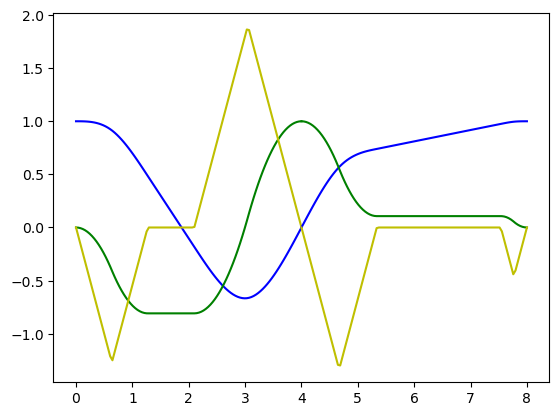

In [137]:
n_wp=100
T= np.linspace(0.0, t1.duration, n_wp)
Y= np.zeros((3,n_wp))
for i in range(n_wp):
    Y[0:3,i] = np.array([x[0] for x in t1.at_time(T[i])])
plt.plot(T, Y[0,:], color='b')
plt.plot(T, Y[1,:], color='g')
plt.plot(T, Y[2,:], color='y')

Y= np.zeros((3,n_wp))
for i in range(n_wp):
    Y[0:3,i] = np.array([x[0] for x in t2.at_time(T[i])])
T= T+t1.duration
plt.plot(T, Y[0,:], color='b')
plt.plot(T, Y[1,:], color='g')
plt.plot(T, Y[2,:], color='y')